In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
import seaborn as sns
import random

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
def events_to_timeseries(frame_times, events, label = 'stim', hrf_model = 'spm'):
    
    if hrf_model is not None:
        events['trial_type']=label
    
    # Note I'm not making a design matrix per se here. Just using the function as convenience to make the timeseries from onsets, durations and amplitudes
    ts = make_first_level_design_matrix(frame_times, events, drift_model=None, hrf_model = hrf_model)
    ts['label'] = label
    ts = ts.rename(columns={label:'amplitude'})
    ts = ts[['label', 'amplitude']]
    ts['time'] = ts.index
    
    return ts

In [23]:
def get_b_est(dv, des_mat, roundto=3, intercept=True):
    dv = dv['amplitude']
    if not intercept:
        des_mat = des_mat.drop(columns='constant')
    des_mat = des_mat.values
    b_est = np.linalg.inv(des_mat.T.dot(des_mat)).dot(des_mat.T).dot(dv)
    b_est = np.round(b_est, roundto)
    return b_est

In [4]:
tr = 1.0
nscans = 200
frame_times = np.arange(nscans) * tr
onsets = np.arange(0, nscans, 20)
durations = np.random.lognormal(mean=1.3, sigma=0.2, size=10)
# amplitudes = np.random.normal(loc=1, scale=.5, size=10)

Variable length stimulus

In [5]:
stim_events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'stim', 'modulation': 1})
stim = events_to_timeseries(frame_times, stim_events, label = 'stim', hrf_model = None)
stim_conv = events_to_timeseries(frame_times, stim_events, label = 'stim_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


This duration of the stimulus can induce different responses. E.g.

- Node responds with longer duration and constant amplitude to longer stimulus
- Node responds with higher amplitude and constant duration to longer stimulus

What do these look like at node level and at the measurable HDR level?

In [17]:
node1_events = pd.DataFrame({'onset': onsets, 'duration': np.where(durations>durations.mean(),durations*2, durations), 'trial_type': 'var_dur_const_amp', 'modulation': 1})
node1 = events_to_timeseries(frame_times, node1_events, label = 'var_dur_const_amp', hrf_model = None)
node1_conv = events_to_timeseries(frame_times, node1_events, label = 'var_dur_const_amp_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [18]:
node2_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'const_dur_const_amp', 'modulation': 1})
node2 = events_to_timeseries(frame_times, node2_events, label = 'const_dur_const_amp', hrf_model = None)
node2_conv = events_to_timeseries(frame_times, node2_events, label = 'const_dur_const_amp_conv', hrf_model = 'spm')

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


In [19]:
node3_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'const_dur_var_amp', 'modulation': np.where(durations>durations.mean(),2, 1)})
node3 = events_to_timeseries(frame_times, node3_events, label = 'const_dur_var_amp', hrf_model = None)
node3_conv = events_to_timeseries(frame_times, node3_events, label = 'const_dur_var_amp_conv', hrf_model = 'spm')


A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


What is problematic below?  

Nodes that respond to longer stimuli with a change in their response duration have convolved responses that are dominated by an increase in amplitude.

<AxesSubplot:xlabel='time', ylabel='amplitude'>

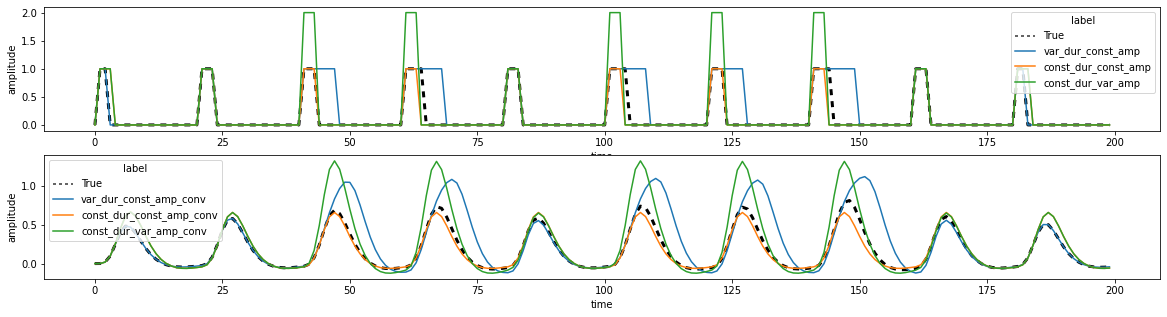

In [20]:
# Plot with nodes overlaid
nodes = pd.concat([node1, node2, node3], ignore_index=True)
nodes_conv = pd.concat([node1_conv, node2_conv, node3_conv], ignore_index=True)

plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(2, 1)
sns.lineplot(data=stim, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[0])
sns.lineplot(data=nodes, x="time", y = "amplitude", hue = "label",  ax=a[0])

sns.lineplot(data=stim_conv, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[1])
sns.lineplot(data=nodes_conv, x="time", y = "amplitude", hue = "label",  ax=a[1])

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


<AxesSubplot:xlabel='time', ylabel='amplitude'>

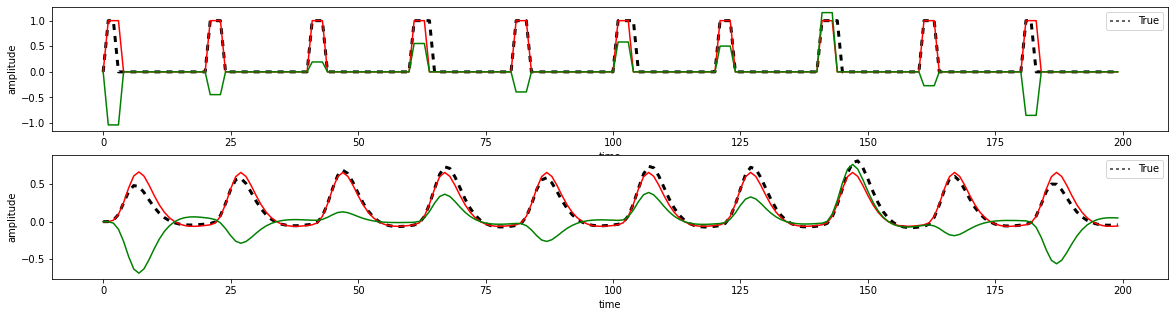

In [21]:
reg1_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'reg1', 'modulation': 1})
reg1 = events_to_timeseries(frame_times, reg1_events, label = 'reg1', hrf_model = None)
reg1_conv = events_to_timeseries(frame_times, reg1_events, label = 'reg1_conv', hrf_model = 'spm')

reg2_events = pd.DataFrame({'onset': onsets, 'duration': durations.mean(), 'trial_type': 'reg2', 'modulation': durations-durations.mean()})
reg2 = events_to_timeseries(frame_times, reg2_events, label = 'reg2', hrf_model = None)
reg2_conv = events_to_timeseries(frame_times, reg2_events, label = 'reg2_conv', hrf_model = 'spm')

# Plot with nodes overlaid

plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(2, 1)
sns.lineplot(data=stim, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[0])
sns.lineplot(data=reg1, x="time", y = "amplitude", color = "red",  ax=a[0])
sns.lineplot(data=reg2, x="time", y = "amplitude", color = "green",  ax=a[0])
# sns.lineplot(data=nodes, x="time", y = "amplitude", hue = "label",  ax=a[0])

sns.lineplot(data=stim_conv, x="time", y="amplitude", style=True, dashes=[(2,2)], color="black", linewidth=3, ax=a[1])
sns.lineplot(data=reg1_conv, x="time", y = "amplitude", color = "red",  ax=a[1])
sns.lineplot(data=reg2_conv, x="time", y = "amplitude", color = "green",  ax=a[1])
# sns.lineplot(data=nodes_conv, x="time", y = "amplitude", hue = "label",  ax=a[1])

In [24]:
des_mat_events = pd.concat([reg1_events, reg2_events], ignore_index=True)
des_mat = make_first_level_design_matrix(frame_times, des_mat_events, drift_model=None, hrf_model = 'spm')
betas = np.vstack((get_b_est(node1_conv, des_mat), get_b_est(node2_conv, des_mat),get_b_est(node3_conv, des_mat)))
pd.DataFrame(betas,
    columns=['reg1 - event', 'reg2 - rt', 'intercept'],
    index=['node1 - var_dur_const_amp',
           'node2 - const_dur_const_amp',
          'node3 - const_dur_var_amp'])

A 'modulation' column was found in the given events data and is used.


,reg1 - event,reg2 - rt,intercept
node1 - var_dur_const_amp,1.018,0.548,0.098
node2 - const_dur_const_amp,1.000,-0.000,0.000
node3 - const_dur_var_amp,1.500,0.666,0.000


In [25]:
des_mat = make_first_level_design_matrix(frame_times, stim_events, drift_model=None, hrf_model = 'spm')

betas = np.vstack((get_b_est(node1_conv, des_mat), get_b_est(node2_conv, des_mat), get_b_est(node3_conv, des_mat)))
pd.DataFrame(betas,
    columns=['stim', 'intercept'],
    index=['node1 - var_dur_const_amp',
           'node2 - const_dur_const_amp',
          'node3 - const_dur_var_amp'])

A 'modulation' column was found in the given events data and is used.


,stim,intercept
node1 - var_dur_const_amp,1.151,0.075
node2 - const_dur_const_amp,0.957,0.008
node3 - const_dur_var_amp,1.550,-0.008
